# RAMP Challenge: Predicting the market value of football players

*Maryem Hajji, Yousra Lina El Khalloufi, Franck Signe Talla, Théodore Trilles, Pierre Fihey, Clément Teulier*



![logo](img/logo.png)

## Table of Contents

- [Introduction](#introduction)
- [The dataset](#the-dataset)
- [Requirements](#Requirements)
- [Data exploration](#Data-exploration)
- [Base model](#base-model)
- [Submitting on RAMP](#submitting-to-the-online-challenge-rampstudio)


## Introduction 

The advent and integration of data analytics in sports have revolutionized player analysis and valuation, reshaping recruitment strategies and team development across the board.

Football clubs, in particular, are increasingly leveraging in-depth data analytics to make informed decisions regarding player transfers, gameplay tactics, and physical training. Football clubs therefore rely on the analysis of the numerous data available to make decisions on which players to recruit. 
The Transfermarket platform, for example, provides a wealth of data on players from the major European leagues. 

The dataset made available by Transfermarket contains data on the teams in the major leagues, the matches that have taken place and the statistics of the players in these matches. All this data can be used to analyze the performances and characteristics of soccer players.

The objective of this challenge is to leverage these historical data to predict the player's highest market values accurately.

By tapping into the wealth of information available, participants will explore various factors that could influence a player's market value, including past performances, age, playing position, injury history, and more. 
Accurately forecasting player market values can shed light on the economic dimensions of football, enabling clubs, analysts, and fans to make informed, data-driven choices.

## The dataset

The dataset provided by Transfermarkt contains information on over 60,000 matches in recent seasons. This includes data on 400 teams from all the major leagues, representing over 30,000 players. 
The data at our disposal includes information on team compositions for each of these matches, as well as the progress of these matches with statistics (scores, fouls, cards, opportunities...). 

The dataset also contains more detailed data on each player as well as their market value, the latter being the target variable for our study. 

All this data is grouped together in several different files and is indexed so that data from different files can be linked for the same players or teams. We will pre-process this data to provide participants with a clean dataframe containing most of the data relevant to the study of player market value. The data will of course remain available to the candidate, who may decide to add certain variables. 

## Requirements

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import missingno as msno
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor

## Data exploration

### Load the data

In [2]:
train_data = pd.read_csv('data/train.csv')
train_data

,player_id,yellow_cards,red_cards,goals,assists,minutes_played,market_value_in_eur,current_club_id,last_season,log_market_value_in_eur
0,53359,17.0,2.0,18.0,10.0,7058.0,4000000.0,720.0,2016.0,15.201805
1,220755,1.0,0.0,1.0,0.0,699.0,1000000.0,29.0,2020.0,13.815511
2,340968,NaN,NaN,NaN,NaN,NaN,50000.0,141.0,2016.0,10.819778
3,192921,0.0,0.0,0.0,1.0,158.0,400000.0,16704.0,2016.0,12.899220
4,227685,0.0,0.0,1.0,0.0,18.0,300000.0,1465.0,2013.0,12.611538
...,...,...,...,...,...,...,...,...,...,...
14671,434295,NaN,NaN,NaN,NaN,NaN,600000.0,2722.0,2018.0,13.304685
14672,60534,5.0,0.0,1.0,0.0,2044.0,2000000.0,252.0,2019.0,14.508658
14673,9832,0.0,0.0,0.0,0.0,221.0,20000000.0,631.0,2012.0,16.811243
14674,276567,NaN,NaN,NaN,NaN,NaN,100000.0,18.0,2017.0,11.512925


In [3]:
test_data = pd.read_csv('data/test.csv')
test_data

,player_id,yellow_cards,red_cards,goals,assists,minutes_played,market_value_in_eur,current_club_id,last_season,log_market_value_in_eur
0,208166,3.0,2.0,0.0,2.0,12420.0,16000000.0,265.0,2023.0,16.588099
1,48835,0.0,0.0,0.0,0.0,120.0,150000.0,6992.0,2017.0,11.918391
2,40617,0.0,0.0,0.0,0.0,70.0,2000000.0,499.0,2013.0,14.508658
3,547528,1.0,0.0,3.0,1.0,720.0,700000.0,11127.0,2023.0,13.458836
4,207922,3.0,0.0,0.0,0.0,578.0,700000.0,366.0,2020.0,13.458836
...,...,...,...,...,...,...,...,...,...,...
14671,146918,2.0,0.0,0.0,0.0,5467.0,1500000.0,1186.0,2022.0,14.220976
14672,72829,0.0,0.0,0.0,0.0,10.0,250000.0,204.0,2012.0,12.429216
14673,341049,15.0,0.0,5.0,2.0,8810.0,13000000.0,371.0,2023.0,16.380460
14674,400545,NaN,NaN,NaN,NaN,NaN,300000.0,865.0,2018.0,12.611538


In [4]:
train_data.columns

Index(['player_id', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played', 'market_value_in_eur', 'current_club_id',
       'last_season', 'log_market_value_in_eur'],
      dtype='object')

In [5]:
### We call the train dataset "players_total" for readability
players_total= train_data

<AxesSubplot:>

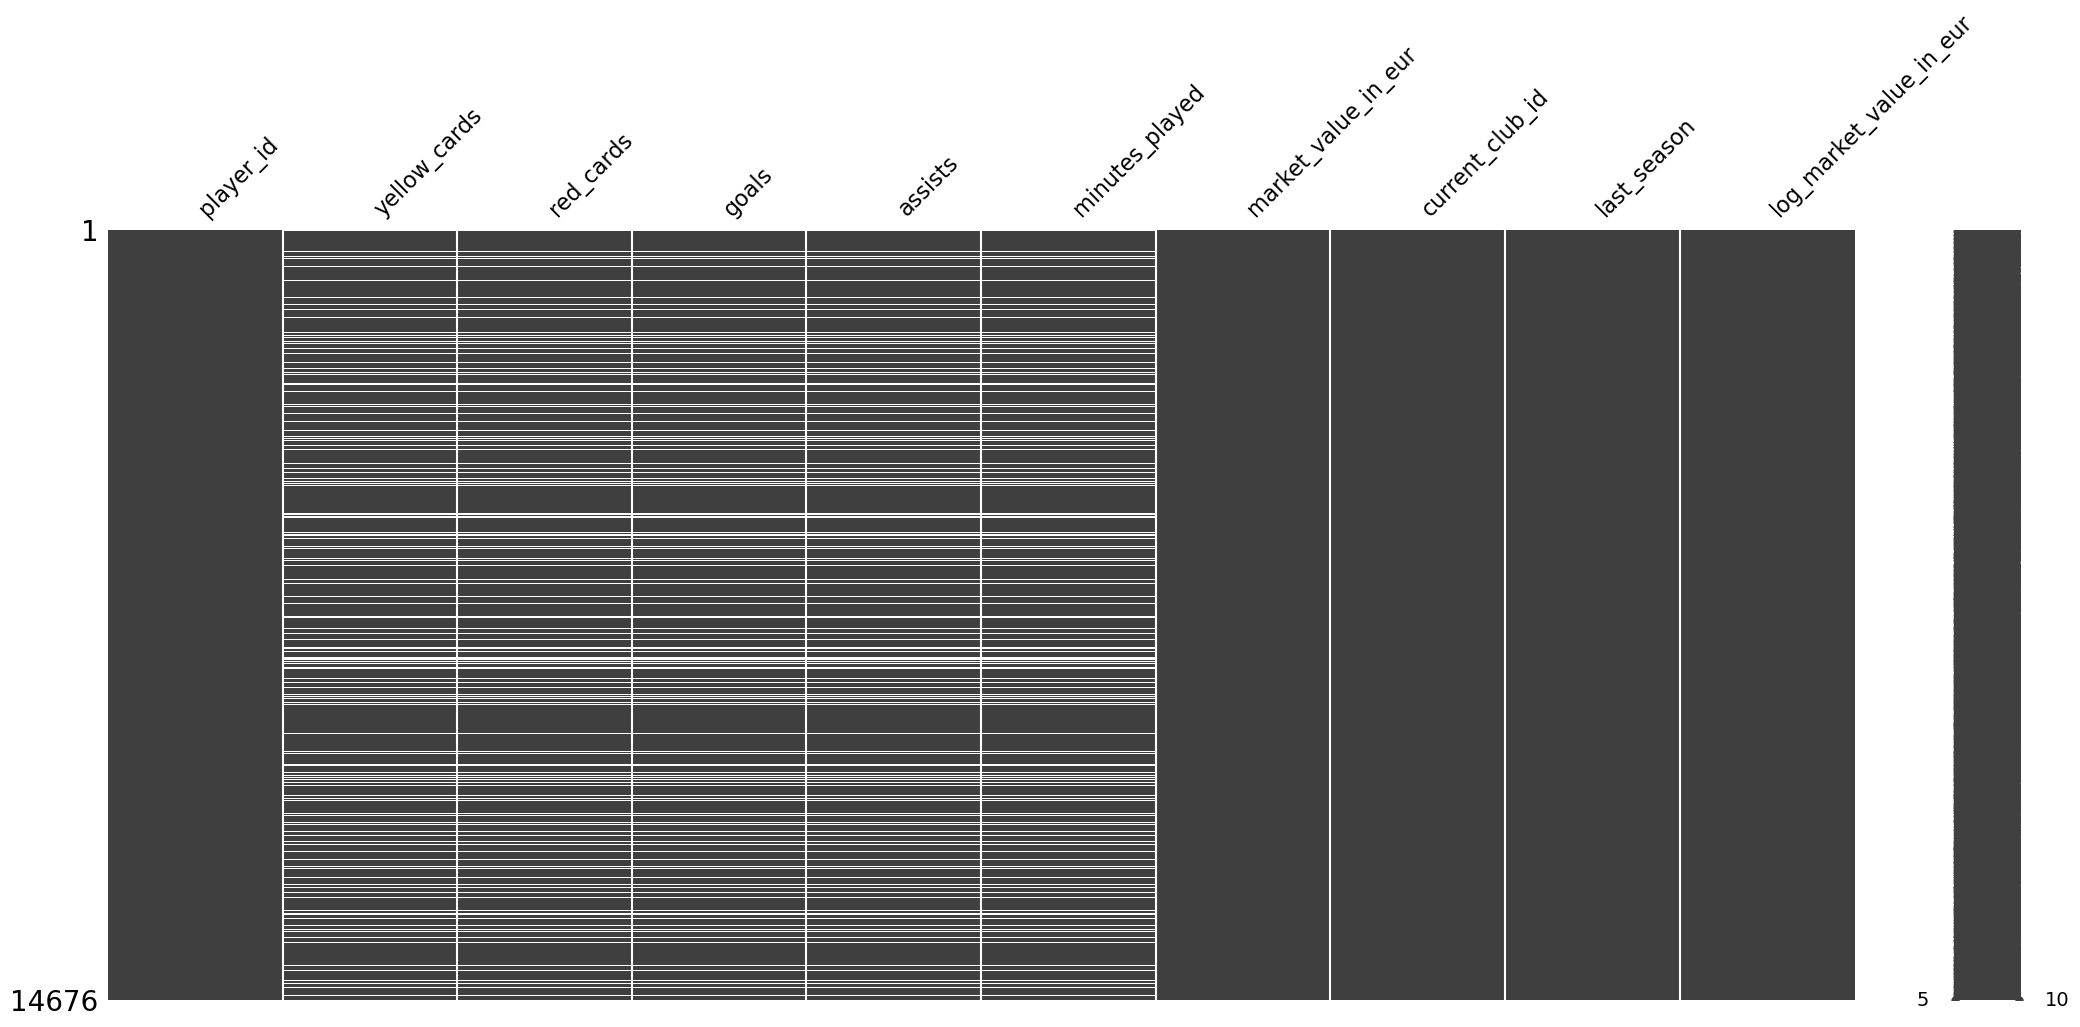

In [6]:
# Missingness
msno.matrix(players_total)

To make our regression possible, we target the "log_market_value_in_eur". We give below some generalities about this variable.

In [7]:
mean_value = players_total["log_market_value_in_eur"].mean()
median_value = players_total["log_market_value_in_eur"].median()
std_dev = players_total["log_market_value_in_eur"].std()
min_value = players_total["log_market_value_in_eur"].min()
max_value = players_total["log_market_value_in_eur"].max()
quantiles = players_total["log_market_value_in_eur"].quantile([0.25, 0.5, 0.75])


print(f"Mean Market Value: {mean_value:.2f} ")
print(f"Median Market Value: {median_value:.2f} ")
print(f"Standard Deviation: {std_dev:.2f} ")
print(f"Minimum Market Value: {min_value:.2f} ")
print(f"Maximum Market Value: {max_value:.2f} ")
print("Quantiles:")
print(quantiles.to_string())

Mean Market Value: 13.69 
Median Market Value: 13.59 
Standard Deviation: 1.68 
Minimum Market Value: 9.21 
Maximum Market Value: 18.83 
Quantiles:
0.25    12.524526
0.50    13.592367
0.75    14.914123


### Data analysis

We try to get a better understanding of the problem at stake in our case.

Let us first study the relationships between variables :

<Figure size 1200x1000 with 0 Axes>

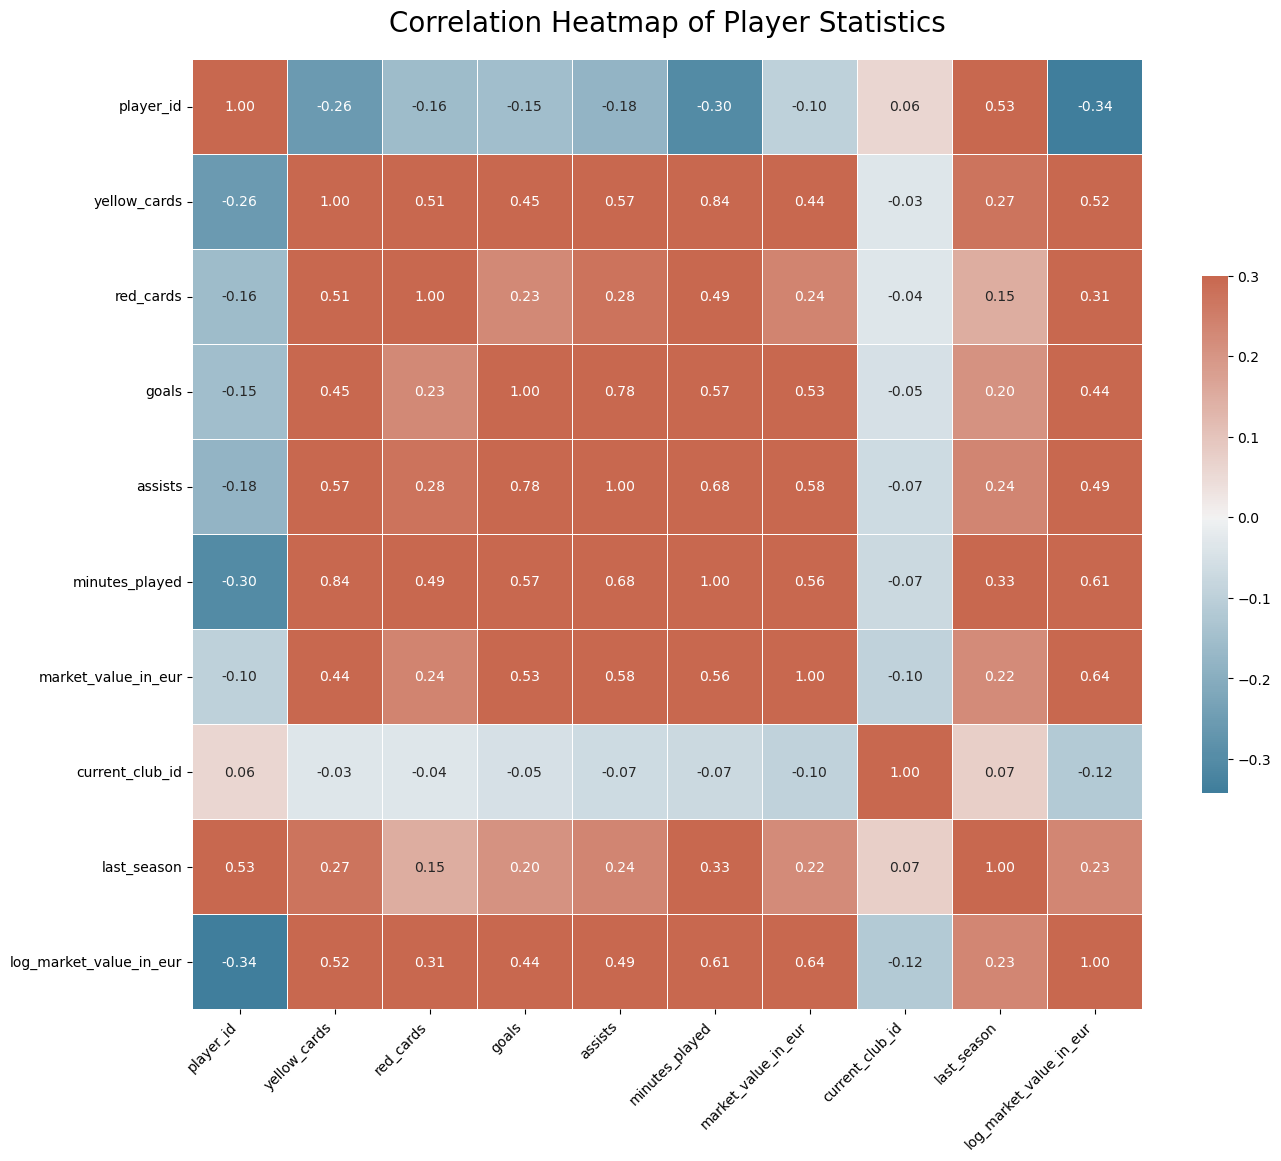

In [8]:
plt.figure(figsize=(12, 10))
corr = players_total.corr()


plt.figure(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            annot=True, 
            square=True,  
            linewidths=.5, cbar_kws={"shrink": .5},  
            fmt=".2f",  
            annot_kws={"size": 10}) 

plt.title('Correlation Heatmap of Player Statistics', size=20, pad=20)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout() 
plt.show()



Due to their correlation in the heatmap above, we can now study deeper the relationships between the market value and the number of goals, assist and minuts played.

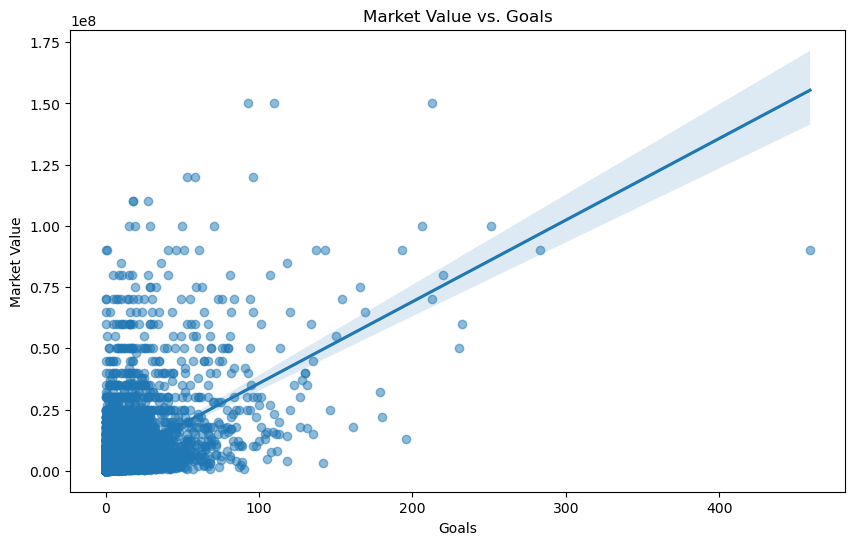

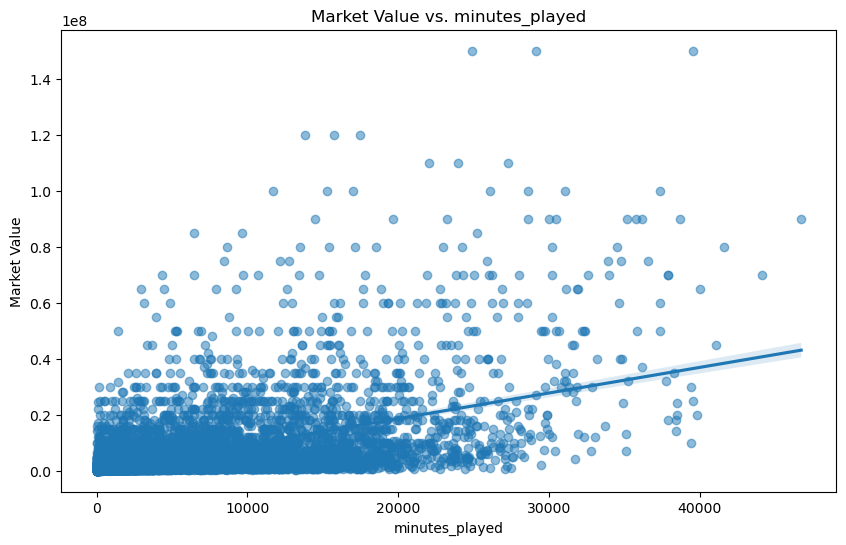

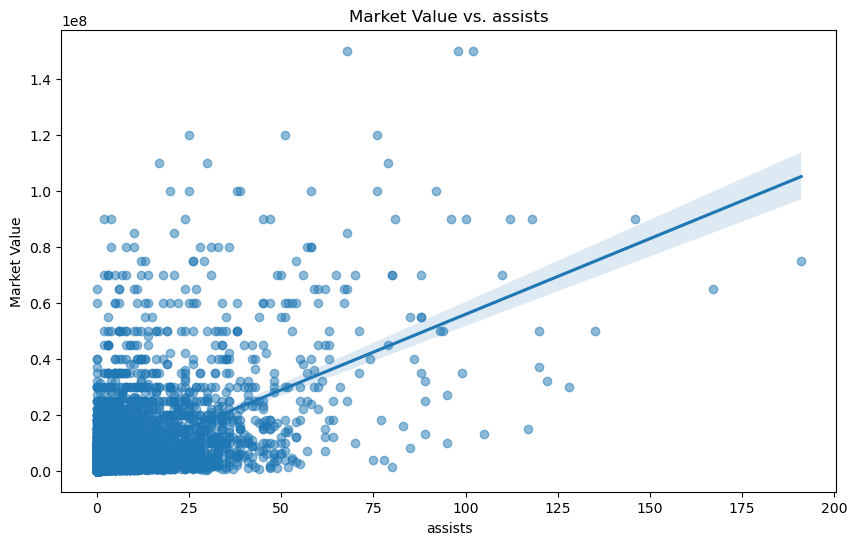

In [9]:
# Market value vs goals

plt.figure(figsize=(10, 6))
sns.regplot(x='goals', y='market_value_in_eur', data=players_total, scatter_kws={'alpha':0.5})
plt.title('Market Value vs. Goals')
plt.xlabel('Goals')
plt.ylabel('Market Value')
plt.show()

# Market value vs minutes played


plt.figure(figsize=(10, 6))
sns.regplot(x='minutes_played', y='market_value_in_eur', data=players_total, scatter_kws={'alpha':0.5})
plt.title('Market Value vs. minutes_played')
plt.xlabel('minutes_played')
plt.ylabel('Market Value')
plt.show()

# Market value vs assists


plt.figure(figsize=(10, 6))
sns.regplot(x='assists', y='market_value_in_eur', data=players_total, scatter_kws={'alpha':0.5})
plt.title('Market Value vs. assists')
plt.xlabel('assists')
plt.ylabel('Market Value')
plt.show()

## Base model

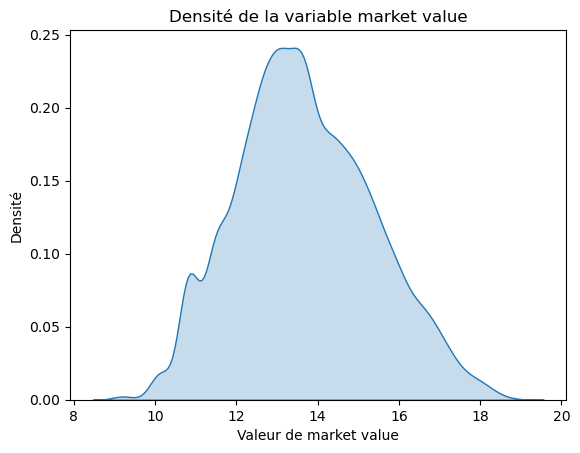

In [10]:
sns.kdeplot(players_total['log_market_value_in_eur'], shade=True)
plt.title(f'Densité de la variable market value')
plt.xlabel(f'Valeur de market value')
plt.ylabel('Densité')
plt.show()

In [11]:
X = players_total.drop('market_value_in_eur', axis=1) 
X = X.drop('log_market_value_in_eur', axis = 1)


y = players_total['log_market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train


,player_id,yellow_cards,red_cards,goals,assists,minutes_played,current_club_id,last_season
13631,242681,NaN,NaN,NaN,NaN,NaN,2288.0,2015.0
12390,5922,0.0,0.0,2.0,1.0,588.0,12.0,2012.0
3546,57367,3.0,0.0,0.0,0.0,2696.0,1421.0,2018.0
8798,557609,NaN,NaN,NaN,NaN,NaN,244.0,2020.0
750,543380,20.0,1.0,9.0,9.0,6610.0,2740.0,2023.0
...,...,...,...,...,...,...,...,...
5191,296674,NaN,NaN,NaN,NaN,NaN,601.0,2013.0
13418,389479,0.0,0.0,0.0,0.0,244.0,6992.0,2018.0
5390,163489,8.0,0.0,1.0,1.0,2656.0,4171.0,2020.0
860,86848,14.0,0.0,4.0,8.0,8286.0,38.0,2019.0


In [12]:
base_transformer= Pipeline(steps=[
            ("imputer", IterativeImputer(max_iter=10, random_state=42)),  
            ("scaler", StandardScaler())  
        ])

We use a simple RandomForest regression.

In [13]:
clf = Pipeline(
    steps=[("transformer", base_transformer), ("regressor", RandomForestRegressor(
        n_estimators=20, max_leaf_nodes=2, random_state=61))]
)

We fit it to our data:

In [14]:
clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('imputer', IterativeImputer(random_state=42)),
                                 ('scaler', StandardScaler())])),
                ('regressor',
                 RandomForestRegressor(max_leaf_nodes=2, n_estimators=20,
                                       random_state=61))])

We evaluate our base model on our test data.

In [15]:
y_predictions= clf.predict(X_test)

In [16]:
y_predictions.shape


(2936,)

In [17]:
mse = mean_squared_error(y_test, y_predictions)
rmse= sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE Score: {rmse}")

MSE: 1.9724420788578072
RMSE Score: 1.4044365698947772


This is the example of a score with a simple RandomForestRegressor.

## Submitting to the online challenge: [ramp.studio](https://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](https://ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://ramp.studio/sign_up), otherwise [log in](https://ramp.studio/login). Then sign up to the event [tephra](https://ramp.studio/events/tephra). Both signups are controlled by RAMP administrators, so there can be a delay between asking for signup and being able to submit.

Once your signup request is accepted, you can go to your [sandbox](https://ramp.studio/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `estimator.py` and upload this file directly. You can check the starting-kit (`estimator.py`) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://ramp.studio/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://ramp.studio/leaderboard). If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://ramp.studio/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., locally, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](https://ramp.studio/leaderboard)) is the balanced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:


In [18]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def get_estimator():
    base_transformer= Pipeline(steps=[
            ("imputer", IterativeImputer(max_iter=10, random_state=42)),  
            ("scaler", StandardScaler())  
        ])
    
    reg = Pipeline(
        steps=[("transformer", base_transformer), ("regressor", RandomForestRegressor(
            n_estimators=20, max_leaf_nodes=2, random_state=61))]
    )
    return reg



You can test your solution locally by running the ramp-test command followed by --submission . Here is an example with the starting_kit submission:

In [19]:
!ramp-test --submission starting_kit

Testing Predicting the market value of a football player
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  rmse  rel_rmse      time
	train  0.97      0.07  0.382978
	valid  0.98      0.07  0.019947
	test   0.96      0.07  0.013532
CV fold 1
	score  rmse  rel_rmse      time
	train  0.97      0.07  0.238552
	valid  0.96      0.07  0.016320
	test   0.96      0.07  0.009103
----------------------------
Mean CV scores
----------------------------
	score          rmse    rel_rmse        time
	train  0.97 ± 0.003  0.07 ± 0.0  0.3 ± 0.07
	valid  0.97 ± 0.013  0.07 ± 0.0   0.0 ± 0.0
	test     0.96 ± 0.0  0.07 ± 0.0   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  rmse  rel_rmse
	valid  0.97      0.07
	test   0.96      0.07
